## prepare dataset

In [39]:
from torchvision import transforms


def build_train_transforms():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            normalize,
        ]
    )


def build_eval_transforms():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize,
        ]
    )

In [40]:
# 1) Imports, device, seeds
import os, time, json, random
from pathlib import Path

import sys as _sys

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from models.resnet_feature_extractor import ResNet18FeatureExtractor
from models.linear_head import LinearHead

# Device & seeds
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print("Using device:", DEVICE)

Using device: cpu


## feature extraction

In [41]:
# 2) Configure paths and hyperparameters (relative paths)
DATA_DIR = Path('../data')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
OUTPUT_DIR = Path('outputs')
MODEL_DIR = Path('models')
GRADCAM_DIR = OUTPUT_DIR / 'gradcam'
for d in [OUTPUT_DIR, MODEL_DIR, GRADCAM_DIR]:
    d.mkdir(parents=True, exist_ok=True)

cfg = {
    'model_name': 'resnet18',
    'pretrained': True,
    'epochs': 3,
    'batch_size': 16,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'num_workers': 0,
    'val_fraction': 0.2,
    'dropout': 0.5,
}


## training setup

In [42]:
# 3) Build datasets and loaders using torchvision ImageFolder + transforms
from torchvision.datasets import ImageFolder

train_tfm = build_train_transforms()
eval_tfm = build_eval_transforms()

# ImageFolder datasets (same files, different transforms)
base_train_ds = ImageFolder(TRAIN_DIR, transform=train_tfm)
base_val_ds   = ImageFolder(TRAIN_DIR, transform=eval_tfm)
test_ds       = ImageFolder(TEST_DIR,  transform=eval_tfm)

# Derive label mapping from dataset
idx_to_class = {idx: cls for cls, idx in base_train_ds.class_to_idx.items()}
with (OUTPUT_DIR / 'labels.json').open('w', encoding='utf-8') as f:
    json.dump(idx_to_class, f, indent=2)
print('Saved labels.json:', idx_to_class)

# Train/val split using shared indices across both train/val views
n = len(base_train_ds)
n_val = max(1, int(n * cfg['val_fraction']))
n_train = n - n_val
gen = torch.Generator().manual_seed(SEED)
train_subset_idx, val_subset_idx = torch.utils.data.random_split(
    list(range(n)), [n_train, n_val], generator=gen)

from torch.utils.data import Subset
train_ds = Subset(base_train_ds, train_subset_idx.indices if hasattr(train_subset_idx,'indices') else train_subset_idx)
val_ds   = Subset(base_val_ds,   val_subset_idx.indices   if hasattr(val_subset_idx,'indices')   else val_subset_idx)

train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['num_workers'])
val_loader   = DataLoader(val_ds,   batch_size=max(32, cfg['batch_size']*2), shuffle=False, num_workers=cfg['num_workers'])
test_loader  = DataLoader(test_ds,  batch_size=max(32, cfg['batch_size']*2), shuffle=False, num_workers=cfg['num_workers'])
print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

Saved labels.json: {0: 'AP', 1: 'Lateral'}
Train/Val/Test sizes: 148/36/27


In [43]:
# 4) Create model (ResNet18FeatureExtractor + LinearHead), unfroze layer4
backbone = ResNet18FeatureExtractor(pretrained=cfg['pretrained'], trainable=True, freeze_mode='layer4')
head = LinearHead(num_classes=len(idx_to_class), in_dim=backbone.feature_dim, hidden_dim=None, dropout=cfg['dropout'])
model = torch.nn.Sequential(backbone, head).to(DEVICE)


In [44]:
# 5) Optimizer, scheduler, and loss (class weights from ImageFolder train subset)
params_to_opt = list(head.parameters()) + [p for p in backbone.layer4.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params_to_opt, lr=cfg['lr'], weight_decay=cfg['weight_decay'])

# Compute class weights from training subset indices over ImageFolder samples
# ImageFolder exposes .samples -> List[(path, class_idx)]
all_labels = [lbl for _, lbl in base_train_ds.samples]
tr_idx = train_subset_idx.indices if hasattr(train_subset_idx, 'indices') else list(train_subset_idx)
import numpy as np
tr_labels = np.array(all_labels)[tr_idx]
c0 = max(1, int(np.sum(tr_labels == 0)))
c1 = max(1, int(np.sum(tr_labels == 1)))
tot = c0 + c1
w0 = tot / (2.0 * c0)
w1 = tot / (2.0 * c1)
class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=DEVICE)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
print('Class weights:', [float(w0), float(w1)])

Class weights: [0.8809523809523809, 1.15625]


## model training

In [45]:
# 6) Training util: train_one_epoch and evaluate
from typing import Tuple

def evaluate(model: torch.nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, np.ndarray]:
    model.eval()
    correct, total = 0, 0
    cm = np.zeros((len(idx_to_class), len(idx_to_class)), dtype=np.int64)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.view(-1).long().to(device)
            logits = model(x)
            if logits.shape[1] == 1:
                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).long().view(-1)
            else:
                preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.numel()
            for t, p in zip(y.view(-1).cpu().numpy(), preds.view(-1).cpu().numpy()):
                cm[int(t), int(p)] += 1
    return correct / max(1, total), cm

def train_one_epoch(model: torch.nn.Module, loader: DataLoader, device: torch.device) -> float:
    model.train()
    running = 0.0
    nsamp = 0
    for x, y in loader:
        x = x.to(device)
        y = y.view(-1).long().to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        bs = x.size(0)
        running += loss.item() * bs
        nsamp += bs
    return running / max(1, nsamp)

## Inference

In [46]:
# 7) Train with early stopping and save best checkpoint
best_acc = 0.0
patience = 3
no_improve = 0
best_path = MODEL_DIR / 'best_model.pth'
for epoch in range(1, cfg['epochs'] + 1):
    t0 = time.perf_counter()
    tr_loss = train_one_epoch(model, train_loader, DEVICE)
    val_acc, val_cm = evaluate(model, val_loader, DEVICE)
    dt = time.perf_counter() - t0
    print(f"Epoch {epoch}: train_loss={tr_loss:.4f} val_acc={val_acc:.3f} time={dt:.1f}s")
    if val_acc > best_acc:
        best_acc = val_acc
        state = {'backbone': backbone.state_dict(), 'head': head.state_dict()}
        torch.save(state, best_path)
        print('Saved best combined checkpoint to', best_path)
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
print('Best val acc:', best_acc)

Epoch 1: train_loss=0.1995 val_acc=0.972 time=9.8s
Saved best combined checkpoint to models\best_model.pth
Epoch 2: train_loss=0.1200 val_acc=0.917 time=9.6s
Epoch 3: train_loss=0.0928 val_acc=0.917 time=10.9s
Best val acc: 0.9722222222222222


In [47]:
# 8) Load best checkpoint into the model (for evaluation)
if best_path.exists():
    state = torch.load(best_path, map_location='cpu')
    try:
        backbone.load_state_dict(state.get('backbone', {}), strict=False)
        head.load_state_dict(state.get('head', {}))
        print('Loaded best checkpoint from', best_path)
    except Exception as e:
        print('Warning: failed to load best checkpoint:', e)
else:
    print('No best checkpoint found at', best_path)

Loaded best checkpoint from models\best_model.pth


Test accuracy: 0.926
Confusion matrix (counts):
 [[13  1]
 [ 1 12]]


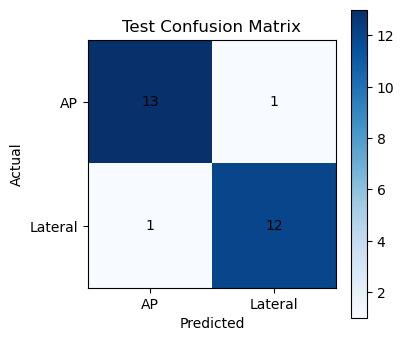

In [48]:
# 9) Evaluate on test set: accuracy and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

test_acc, test_cm_counts = evaluate(model, test_loader, DEVICE)
print(f"Test accuracy: {test_acc:.3f}")
print('Confusion matrix (counts):\n', test_cm_counts)

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(test_cm_counts, cmap='Blues')
ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks([0,1], labels=[idx_to_class[0], idx_to_class[1]])
ax.set_yticks([0,1], labels=[idx_to_class[0], idx_to_class[1]])
for i in range(2):
    for j in range(2):
        ax.text(j, i, int(test_cm_counts[i, j]), ha='center', va='center', color='black')
fig.colorbar(im, ax=ax)
plt.show()